In [227]:
import sys
import os

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn.metrics

mpl.rcParams['figure.dpi'] = 100
plt.style.use(['dark_background'])

In [124]:
def read_theoretical(path):
    # Read the theoretical starfile
    # We only want (1-indexed): 2 (psi), 3 (phi), 4 (theta), 12 (originX), 13 (originY) 
    # BEWARE skiprows, starfile header lengths may vary
    theoretical = pd.read_csv(path, delim_whitespace=True, header=None, skiprows=21)
    theoretical = theoretical[theoretical.columns[[1, 2, 3, 11, 12]]]
    theoretical.columns = [ 'psi', 'phi', 'theta', 'shiftX', 'shiftY']
    theoretical = theoretical.astype(float)
    return theoretical

In [125]:
def read_experimental(path):
    # Read the experimental parfile
    # BEWARE dropping last two rows.
    experimental = pd.read_csv(path, delim_whitespace=True)
    experimental = experimental[experimental.columns[[1, 3, 2, 4, 5]]]
    experimental.columns = [ 'psi', 'phi', 'theta', 'shiftX', 'shiftY']
    experimental.drop(experimental.tail(2).index,inplace=True)
    experimental = experimental.astype(float)
    return experimental

In [277]:
temet_theoretical = read_theoretical('alignment_data/0.001_temet_simulated.star')
wt_theoretical = read_theoretical('alignment_data/0.001_wt_simulated.star')

temet_experimental = read_experimental('alignment_data/0.001_temet_output.par')
wt_experimental = read_experimental('alignment_data/0.001_wt_output.par')

In [259]:
# Calculate root mean square error
def angDist(a,b):
    d = a - b
    d = (d + 180) % 360 - 180
    return abs(d)

def rmse(predictions, targets):
    d = angDist(predictions, targets)
    return sum(d)/len(d)
#     return np.sqrt(((d) ** 2).mean())

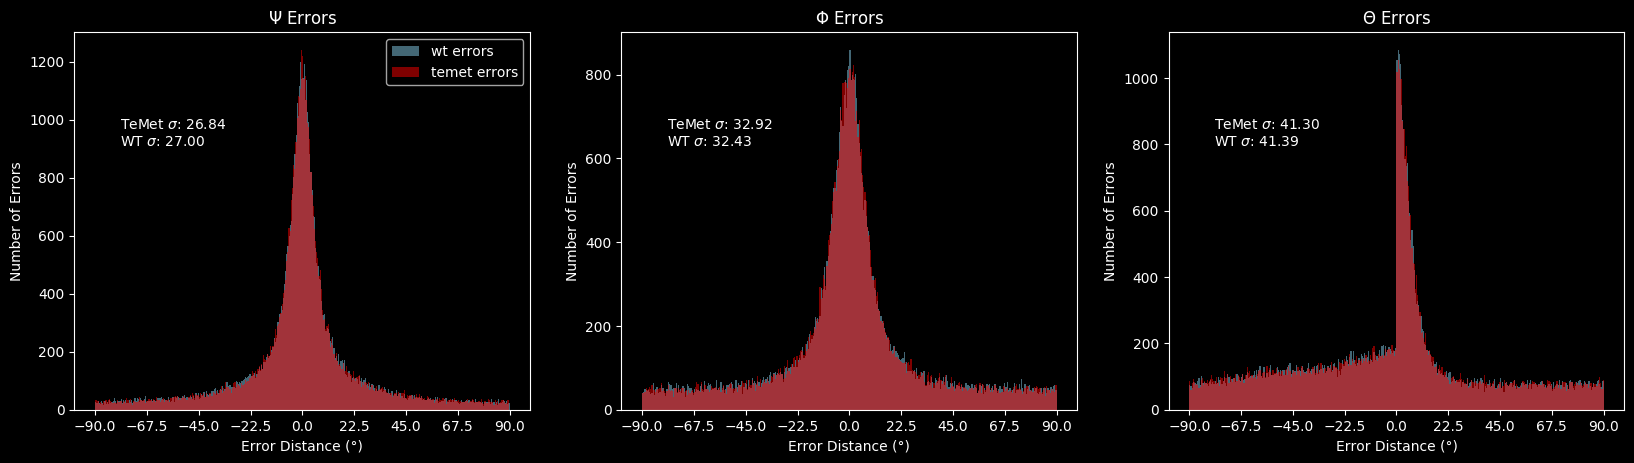

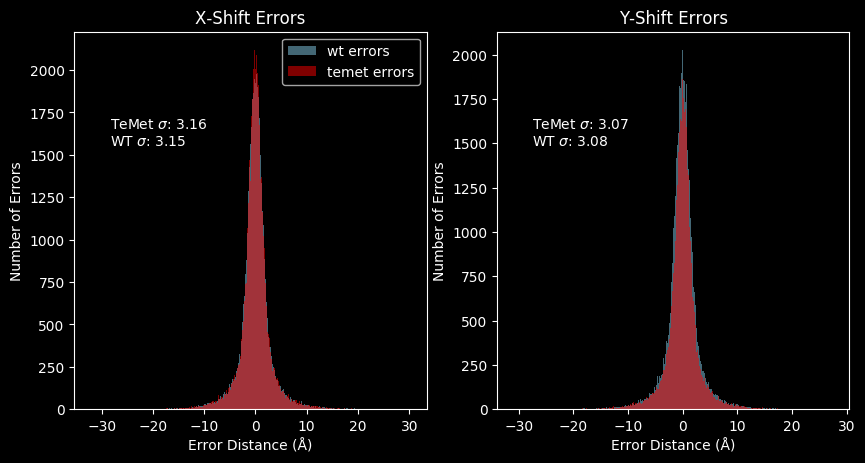

In [284]:
wt_errors = (angDist(wt_theoretical, wt_experimental)+90)%180 - 90
temet_errors = (angDist(temet_theoretical, temet_experimental)+90)%180 - 90

import matplotlib.ticker as ticker

def plotErrors(wt, temet, ax, title, wt_rmse, temet_rmse):
    ax.hist((wt), bins=360, alpha=0.5, color='skyblue', label='wt errors');
    ax.hist((temet), bins=360, alpha=0.5,color='red', label='temet errors');
    ax.title.set_text(title)
    ax.set_xlabel("Error Distance (°)")
    ax.set_ylabel("Number of Errors")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(22.5))
    ax.text(0.1,0.7,"TeMet $\sigma$: %.2f \nWT $\sigma$: %.2f" % (temet_rmse, wt_rmse),transform=ax.transAxes)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

plotErrors(wt_errors.psi, temet_errors.psi, ax1, '$\Psi$ Errors', np.std(temet_errors.psi), np.std(wt_errors.psi))
plotErrors(wt_errors.phi, temet_errors.phi, ax2, '$\Phi$ Errors', np.std(temet_errors.phi), np.std(wt_errors.phi))
plotErrors(wt_errors.theta, temet_errors.theta, ax3, '$\Theta$ Errors', np.std(temet_errors.theta), np.std(wt_errors.theta))

ax1.legend()

wt_errors = wt_theoretical-wt_experimental
temet_errors =temet_theoretical-temet_experimental
def plotShiftErrors(wt, temet, ax, title, wt_rmse, temet_rmse):
    ax.hist((wt), bins=360, alpha=0.5, color='skyblue', label='wt errors');
    ax.hist((temet), bins=360, alpha=0.5,color='red', label='temet errors');
    ax.title.set_text(title)
    ax.set_xlabel("Error Distance (Å)")
    ax.set_ylabel("Number of Errors")
    ax.text(0.1,0.7,"TeMet $\sigma$: %.2f \nWT $\sigma$: %.2f" % (temet_rmse, wt_rmse),transform=ax.transAxes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

plotShiftErrors(wt_errors.shiftX, temet_errors.shiftX, ax1, 'X-Shift Errors', np.std(temet_errors.shiftX), np.std(wt_errors.shiftX))
plotShiftErrors(wt_errors.shiftY, temet_errors.shiftY, ax2, 'Y-Shift Errors', np.std(temet_errors.shiftY), np.std(wt_errors.shiftY))
ax1.legend()